In [14]:
from gerrychain import Graph

In [15]:
# Read Iowa county graph from the json file "IA_county.json"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [16]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    print("Node",node,"represents",county_name,"County, which had a population of",county_population,"in the 2020 census.")

Node 0 represents Wright County, which had a population of 12943 in the 2020 census.
Node 1 represents Montgomery County, which had a population of 10330 in the 2020 census.
Node 2 represents Union County, which had a population of 12138 in the 2020 census.
Node 3 represents Keokuk County, which had a population of 10033 in the 2020 census.
Node 4 represents Story County, which had a population of 98537 in the 2020 census.
Node 5 represents Mitchell County, which had a population of 10565 in the 2020 census.
Node 6 represents Grundy County, which had a population of 12329 in the 2020 census.
Node 7 represents Winneshiek County, which had a population of 20070 in the 2020 census.
Node 8 represents Polk County, which had a population of 492401 in the 2020 census.
Node 9 represents Sac County, which had a population of 9814 in the 2020 census.
Node 10 represents Marshall County, which had a population of 40105 in the 2020 census.
Node 11 represents Delaware County, which had a population 

In [17]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01

k = 4  # desired number of districts
total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
ideal_population = total_population / k

import math
L = math.ceil( ( 1 - deviation / 2 ) * ideal_population )
U = math.floor( ( 1 + deviation / 2 ) * ideal_population )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 793605 and U = 801580 and k = 4


In [18]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY ) # x[i,j] = 1 if county i is assigned to district j
y = m.addVars( G.edges, vtype=GRB.BINARY )    # y[u,v] = 1 when edge {u,v} is cut

In [19]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

## Equivalently, we could write:
#m.setObjective( gp.quicksum( y ), GRB.MINIMIZE )

In [20]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [21]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 995 rows, 618 columns and 3852 nonzeros
Model fingerprint: 0xb8e8a484
Variable types: 0 continuous, 618 integer (618 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.00s
Presolved: 995 rows, 618 columns, 3852 nonzeros
Variable types: 0 continuous, 618 integer (618 binary)
Found heuristic solution: objective 152.0000000
Found heuristic solution: objective 135.0000000

Root relaxation: objective 0.000000e+00, 639 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

 169589 21140     cutoff   32        33.00000   28.92137  12.4%   111  350s
 172798 20923     cutoff   29        33.00000   28.97892  12.2%   111  356s
 175302 20727   30.88904   30  345   33.00000   29.03414  12.0%   111  360s
 178675 20508   30.35584   36  374   33.00000   29.10351  11.8%   111  365s
 181809 20242   30.76381   31  314   33.00000   29.16770  11.6%   110  371s
 184330 19985     cutoff   27        33.00000   29.21993  11.5%   110  375s
 187641 19624     cutoff   29        33.00000   29.29225  11.2%   110  380s
 191004 19230   31.73234   38  172   33.00000   29.36218  11.0%   110  386s
 193392 18929   31.49581   27  326   33.00000   29.40917  10.9%   109  390s
 196597 18513   31.49819   28  362   33.00000   29.48121  10.7%   109  396s
 199198 18215   31.22117   29  319   33.00000   29.53590  10.5%   109  400s
 201483 17978   31.06098   28  388   33.00000   29.59240  10.3%   109  405s
 203968 17410     cutoff   28        33.00000   29.65283  10.1%   109  410s
 207454 1681

In [22]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The number of cut edges is 33.0
District 0 has these nodes = [0, 5, 6, 7, 10, 11, 13, 16, 29, 34, 36, 45, 49, 50, 51, 56, 57, 69, 74, 75, 77, 80, 81, 83, 85, 88, 90] and this population = 797903
The corresponding county names are = ['Wright', 'Mitchell', 'Grundy', 'Winneshiek', 'Marshall', 'Delaware', 'Floyd', 'Hardin', 'Butler', 'Buchanan', 'Cerro Gordo', 'Tama', 'Hamilton', 'Franklin', 'Bremer', 'Allamakee', 'Winnebago', 'Howard', 'Worth', 'Black Hawk', 'Fayette', 'Chickasaw', 'Hancock', 'Poweshiek', 'Benton', 'Linn', 'Clayton']

District 1 has these nodes = [1, 2, 9, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 52, 53, 55, 58, 59, 60, 62, 63, 64, 65, 66, 68, 70, 71, 73, 76, 79, 84, 89, 91, 92, 93] and this population = 798391
The corresponding county names are = ['Montgomery', 'Union', 'Sac', 'Audubon', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Greene', 'Lyon', 'Adams', 'Monona', 

In [23]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 5, 6, 7, 10, 11, 13, 16, 29, 34, 36, 45, 49, 50, 51, 56, 57, 69, 74, 75, 77, 80, 81, 83, 85, 88, 90] connected? True
Is district = [1, 2, 9, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 52, 53, 55, 58, 59, 60, 62, 63, 64, 65, 66, 68, 70, 71, 73, 76, 79, 84, 89, 91, 92, 93] connected? True
Is district = [4, 8, 17, 18, 46, 48, 78, 86, 94, 95, 96] connected? True
Is district = [3, 12, 15, 24, 25, 26, 28, 38, 39, 44, 47, 54, 61, 67, 72, 82, 87, 97, 98] connected? True


In [24]:
# Let's draw it on a map
import geopandas as gpd

In [25]:
# Read Iowa county shapefile from "IA_county.shp"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

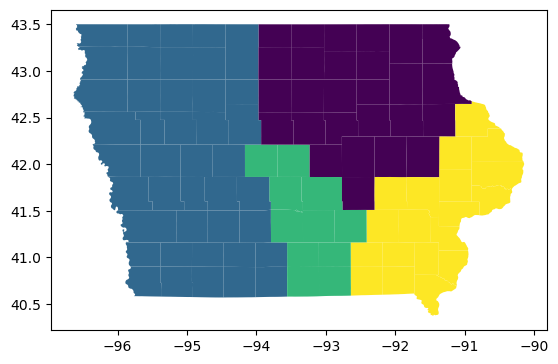

In [26]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()